In [1]:
import pandas as pd
import sys
from pathlib import Path
import pastas as ps

# Add the 'scripts' directory to sys.path
scripts_path = Path("../scripts").resolve()
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))


### Loading Input Files

In [2]:
from knmi_pull import fetch_knmi_prec_evap
data = fetch_knmi_prec_evap("249", "2000-01-01", "2025-06-01")

In [3]:
prec = data[0]
evap = data[1]

In [4]:
# 1. Load Excel file
file_path_excel = Path("../input_files/input_single/F229_Beemster_goed.xlsx")
df_head = pd.read_excel(file_path_excel)

In [5]:
print(df_head.head())

                  time   head
0  10:50:00 01-02-2023 -1.426
1  11:00:00 01-02-2023 -1.427
2  11:10:00 01-02-2023 -1.427
3  11:20:00 01-02-2023 -1.428
4  11:30:00 01-02-2023 -1.429


In [6]:
# 2. Convert 'time' column to datetime using flexible parsing
df_head['time'] = pd.to_datetime(df_head['time'], format='mixed', dayfirst=True)

# 3. Set datetime column as index
df_head.set_index('time', inplace=True)

# 4. Resample to daily mean
head_daily_mean = df_head['head'].resample("D").mean().dropna()

In [7]:
print(head_daily_mean.head())

time
2023-02-01   -1.425532
2023-02-02   -1.430222
2023-02-03   -1.455167
2023-02-04   -1.485146
2023-02-05   -1.459250
Name: head, dtype: float64


#### Waterhoogte systeem

In [8]:
# 1. Load Excel file
file_path_waterhoogte = Path("../input_files/input_single/waterhoogte_drieban.xlsx")
df = pd.read_excel(file_path_waterhoogte)

# 2. Convert 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# 3. Set datetime as index
df.set_index('datetime', inplace=True)

# 4. Resample to daily mean (will have missing dates if no data on some days)
waterhoogte_daily_mean = df['waterhoogte'].resample("D").mean()

# 5. Fill missing days with a method or value, e.g., forward fill or zero (if appropriate)
waterhoogte_daily_mean = waterhoogte_daily_mean.ffill()  # or .bfill(), or .fillna(0)

# 6. Now frequency can be inferred correctly
waterhoogte_daily_mean.index.freq = "D"

### Gegevenscontrole

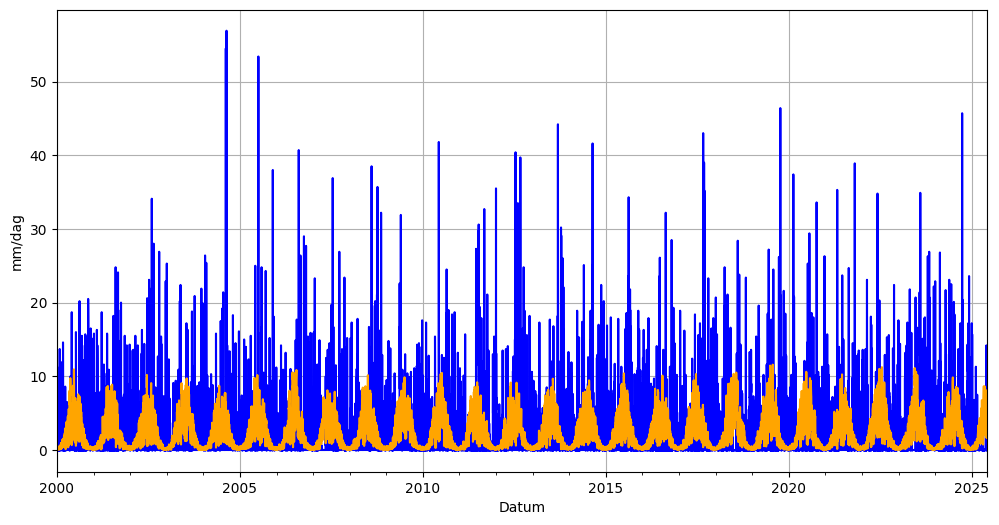

In [9]:
import matplotlib.pyplot as plt

ax1 = prec.plot(label='Precipitation', color='blue', figsize=(12, 6))
ax2 = evap.plot(label='Evaporation', color='orange')
plt.xlabel("Datum")
plt.ylabel("mm/dag")  # or your preferred unit
plt.grid(True)
plt.show()

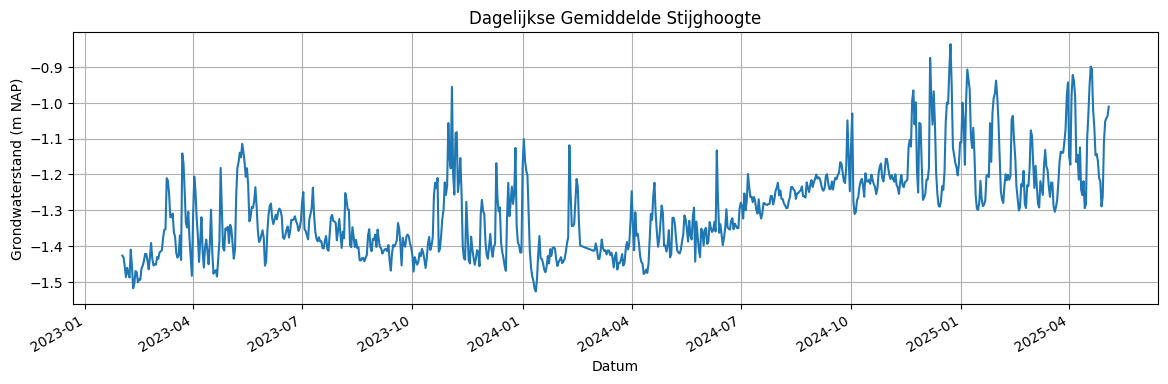

In [10]:
head_daily_mean.plot(figsize=(14, 4), title="Dagelijkse Gemiddelde Stijghoogte")
plt.xlabel("Datum")
plt.ylabel("Grondwaterstand (m NAP)")  # or your preferred unit
plt.grid(True)
plt.show()


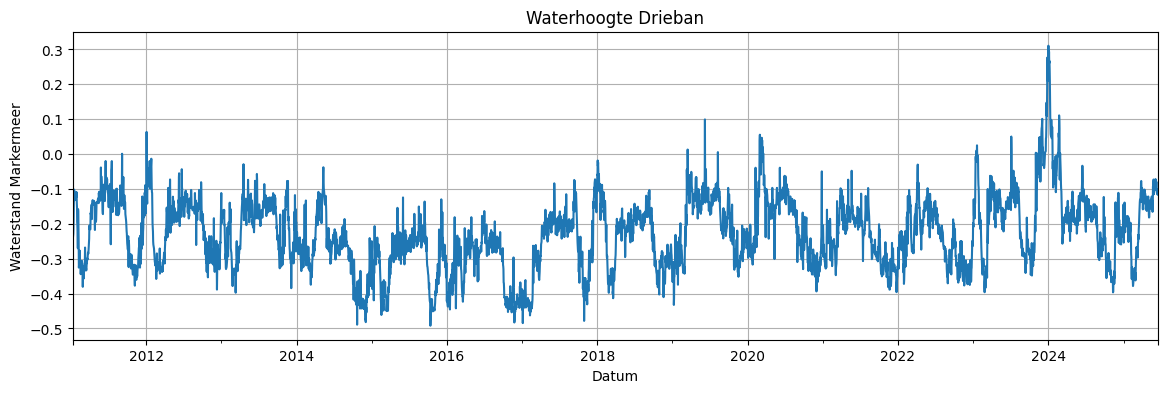

In [11]:
waterhoogte_daily_mean.plot(figsize=(14, 4), title="Waterhoogte Drieban")
plt.xlabel("Datum")
plt.ylabel("Waterstand Markermeer")  # or your preferred unit
plt.grid(True)
plt.show()


In [12]:
print(waterhoogte_daily_mean.tail(30))

datetime
2025-05-19   -0.132375
2025-05-20   -0.132044
2025-05-21   -0.133759
2025-05-22   -0.165615
2025-05-23   -0.151281
2025-05-24   -0.093135
2025-05-25   -0.106635
2025-05-26   -0.116042
2025-05-27   -0.072969
2025-05-28   -0.114729
2025-05-29   -0.078344
2025-05-30   -0.090281
2025-05-31   -0.104125
2025-06-01   -0.088292
2025-06-02   -0.100906
2025-06-03   -0.073500
2025-06-04   -0.095542
2025-06-05   -0.075729
2025-06-06   -0.072198
2025-06-07   -0.097333
2025-06-08   -0.097583
2025-06-09   -0.080635
2025-06-10   -0.079250
2025-06-11   -0.108240
2025-06-12   -0.108490
2025-06-13   -0.113021
2025-06-14   -0.105292
2025-06-15   -0.108573
2025-06-16   -0.116677
2025-06-17   -0.101102
Freq: D, Name: waterhoogte, dtype: float64


### Model neerzetten

In [13]:
start_head_series = head_daily_mean.index.min()
end_head_series = head_daily_mean.index.max()

print(start_head_series, end_head_series)

2023-02-01 00:00:00 2025-05-04 00:00:00


Fit report NonlinearRechargeModel Fit Statistics
nfev    36                     EVP         49.43
nobs    814                    R2           0.49
noise   False                  RMSE         0.09
tmin    2023-02-01 00:00:00    AICc     -3936.14
tmax    2025-05-04 00:00:00    BIC      -3917.38
freq    D                      Obj          3.20
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
               optimal    initial  vary
extra_A      20.941462   9.805271  True
extra_n       2.807045   1.000000  True
extra_a     583.848273  10.000000  True
constant_d    3.368004  -1.296714  True

Warnings! (2)
Response tmax for 'extra' > than calibration period.
Response tmax for 'extra' > than warmup period.


[<Axes: xlabel='time', ylabel='Head'>,
 <Axes: xlabel='time'>,
 <Axes: title={'right': "Stresses: ['waterhoogte']"}, xlabel='datetime', ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=4)'}>]

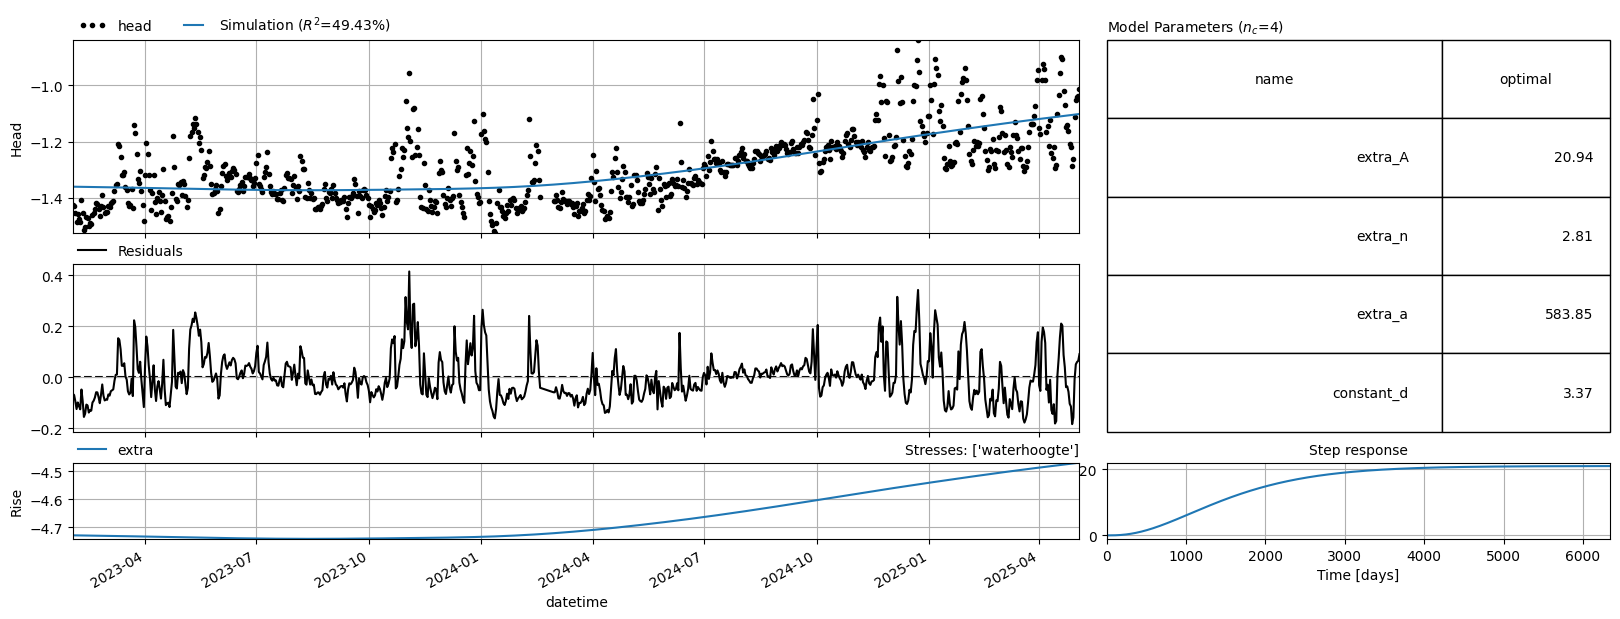

In [ ]:
# 1. Create the model
ml = ps.Model(head_daily_mean, name="NonlinearRechargeModel")

# 2. Define recharge model
rch = ps.rch.Linear()  # Nonlinear recharge function

# 2. Define the stress model with a response function
rm = ps.RechargeModel(
    prec=prec,
    evap=evap,
    recharge=rch,                    # ← How recharge is computed
    rfunc=ps.DoubleExponential(),    # ← How system responds to recharge
    name="rch"
)

# Optional: add extra stressor if needed
extra = ps.StressModel(waterhoogte_daily_mean, rfunc=ps.Gamma(), name="extra", settings="prec", up=True)
ml.add_stressmodel(extra)

# 3. Solve the model
ml.solve(tmin=start_head_series, tmax=end_head_series, solver=ps.LeastSquares(), report=True)

# 4. Plot results
ml.plots.results(figsize=(16, 6))

array([<Axes: xlabel='time', ylabel='Head'>,
       <Axes: title={'center': 'extra'}, xlabel='datetime', ylabel='Rise'>],
      dtype=object)

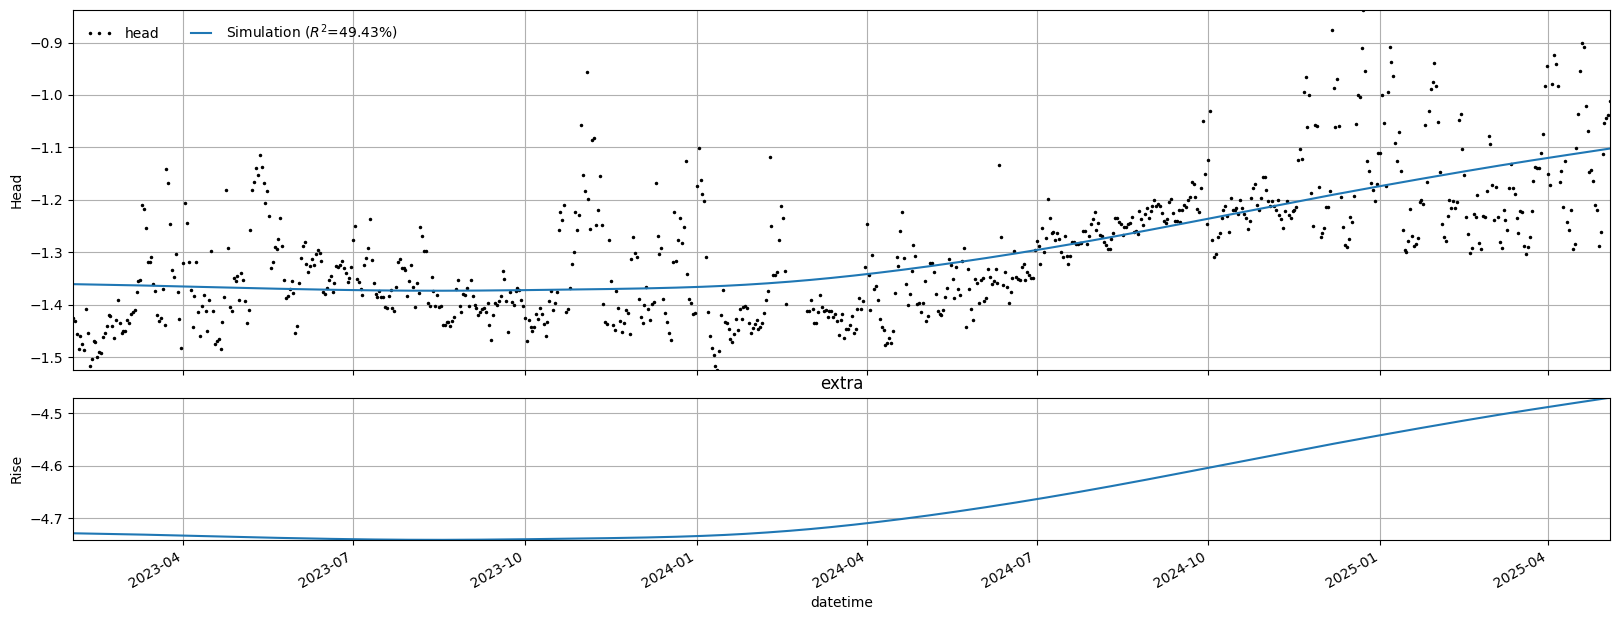

In [15]:
ml.plots.decomposition(figsize=(16, 6))

Fit report TarsoModel             Fit Statistics
nfev    27                     EVP         15.17
nobs    814                    R2           0.15
noise   False                  RMSE         0.11
tmin    2023-02-01 00:00:00    AICc     -3508.93
tmax    2025-05-04 00:00:00    BIC      -3476.16
freq    D                      Obj          5.37
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (7 optimized)
               optimal     initial  vary
tarso_A0  3.137066e-01    1.000000  True
tarso_a0  1.000000e+03  100.000000  True
tarso_d0 -2.080260e+00   -0.090776  True
tarso_A1  2.631804e+01    1.000000  True
tarso_a1  2.605169e+01  100.000000  True
tarso_d1 -4.920937e-01    0.109883  True
tarso_f  -6.397859e-13   -1.000000  True

Warnings! (5)
Parameter 'tarso_a0' on upper bound: 1.00e+03
Parameter 'tarso_d1' on lower bound: -4.92e-01
Parameter 'tarso_f' on upper bound: 0.00e+00
Response tmax for 'tarso' > than calibration period.

[<Axes: xlabel='time', ylabel='Head'>,
 <Axes: xlabel='time'>,
 <Axes: title={'right': "Stresses: ['Precipitation', 'ET']"}, xlabel='DATE', ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=7)'}>]

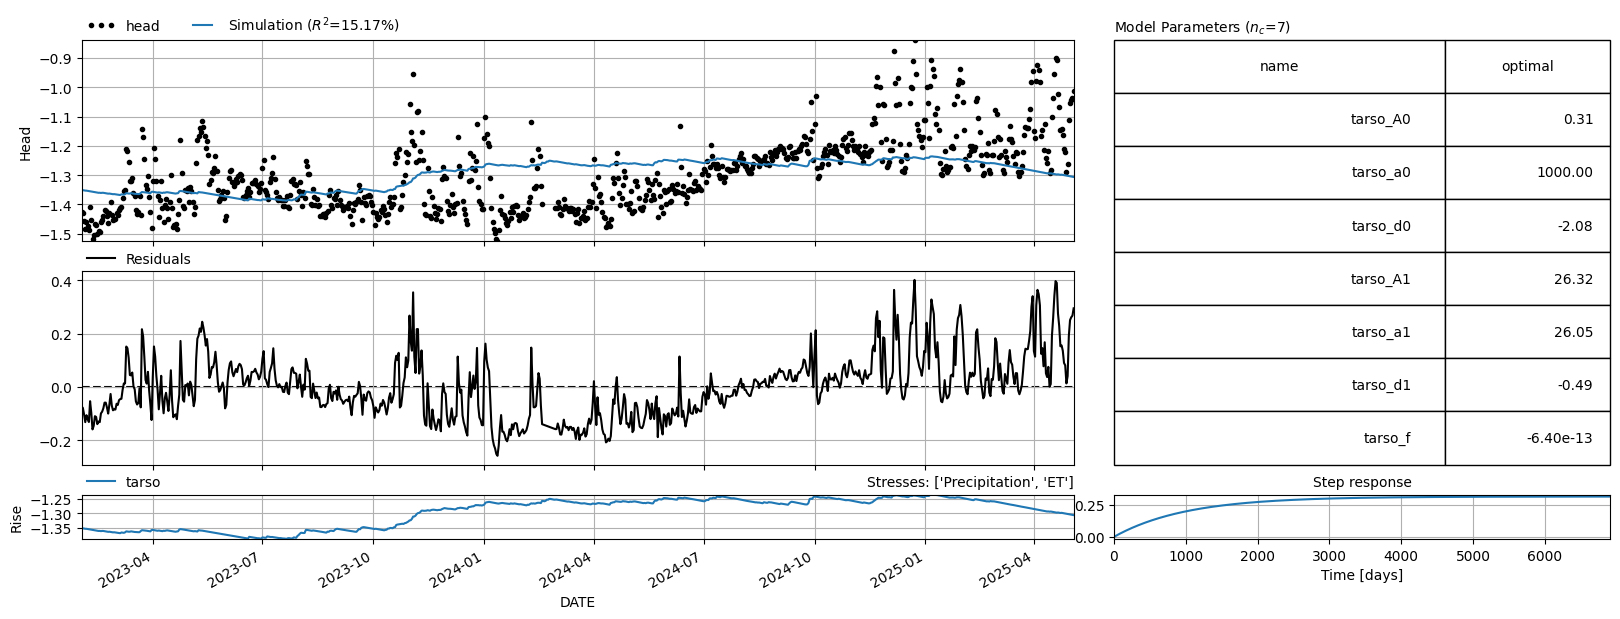

In [16]:
# 1. Create the model without a constant (TARSO doesn't support constants)
ml2 = ps.Model(head_daily_mean, name="TarsoModel")

# 2. Define the TarsoModel recharge stressmodel
tarso = ps.TarsoModel(
    prec=prec,
    evap=evap,
    oseries=waterhoogte_daily_mean,  # Threshold (drainage) series
    rfunc=ps.Exponential(),          # Response function (Gamma, DoubleExponential also possible)
    name="tarso"
)

# TarsoModel does not require a constant term, so remove it
ml2.del_constant()

# 3. Add the Tarso stress model to the model
ml2.add_stressmodel(tarso)

# 4. Set parameter bounds (optional, helps model convergence)
ml2.set_parameter("tarso_a0", pmin=10, pmax=1000, initial=100)
ml2.set_parameter("tarso_a1", pmin=10, pmax=1000, initial=100)
ml2.set_parameter("tarso_A0", pmin=0.1, pmax=100, initial=1.0)
ml2.set_parameter("tarso_A1", pmin=0.1, pmax=100, initial=1.0)

# 5. Define the modeling period (aligned with data)
tmin = max(head_daily_mean.index.min(), prec.index.min(), evap.index.min(), waterhoogte_daily_mean.index.min())
tmax = min(head_daily_mean.index.max(), prec.index.max(), evap.index.max(), waterhoogte_daily_mean.index.max())

# 6. Solve the TARSO model
ml2.solve(
    tmin=tmin,
    tmax=tmax,
    warmup=3650,  # 10 years warm-up recommended for TARSO
    report=True,
    solver=ps.LeastSquares()
)

# 7. Plot results
ml2.plots.results(figsize=(16, 6))
